In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import torch
 
import torch.nn as nn
 
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn import Module, Sequential, Conv2d, ConvTranspose2d, LeakyReLU, BatchNorm2d, ReLU, Tanh, Sigmoid, BCELoss 
 
%matplotlib inline

#set device 
dev = 'cuda:0' if torch.cuda.is_available() == True else 'cpu'
device = torch.device(dev)

In [2]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 99

# Size of feature maps in generator
ngf = 60 #MUST BE DIVISIBLE BY 3!!!

# Size of feature maps in discriminator
ndf = 64


class BigGenerator(nn.Module):
    def __init__(self):
        super(BigGenerator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*16) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 32 x 32``
            nn.ConvTranspose2d( ngf * 1, nc * 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc * 3) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)
        
class SetDiscriminator(nn.Module):
    def __init__(self):
        super(SetDiscriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc*3) x 64 x 64``
            nn.Conv2d(nc*3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

class ImageDiscriminator(nn.Module):
    def __init__(self):
        super(ImageDiscriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [3]:
netG = BigGenerator()
netD = SetDiscriminator()
netD_img = ImageDiscriminator()
netG = netG.to(device)
netD = netD.to(device)
netD_img = netD_img.to(device)

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

print('PARAM COUNT: ', get_n_params(netG), get_n_params(netD))

def init_weights(m):
    if type(m) == ConvTranspose2d:
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif type(m) == BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)
        
# initializing the weights
netD.apply(init_weights)
netD_img.apply(init_weights)
netG.apply(init_weights)

PARAM COUNT:  3189960 2771712


BigGenerator(
  (main): Sequential(
    (0): ConvTranspose2d(99, 480, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(480, 240, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(240, 120, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(120, 60, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(60, 9, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )


In [4]:
def get_onehot_encodings(label):
    encoding = []
    for c in label:
        if c == 'C': #circle
            enc = [1, 0, 0]
        elif c == 'S': #square
            enc = [0, 1, 0]
        elif c == 'T': #triangle
            enc = [0, 0, 1]
        encoding.extend(enc)
    return np.array(encoding)     

enc = get_onehot_encodings('SST')
print(enc.shape)

(9,)


In [5]:
import numpy as np
class SetDatasetWithLabels(Dataset):
    """set dataset."""
 
    def __init__(self, imgs_path, labels_path):
        """
        Args:
            npz_imgs (string): npz file with all the images (created in gan.ipynb)
        """
        self.num_images = 3
        self.dict_data = np.load(imgs_path)
        self.sets_raw = self.dict_data['arr_0']
        self.dict_data_2 = np.load(labels_path)
        self.labels_raw = self.dict_data_2['arr_0']
        self.labels = [get_onehot_encodings(l) for l in self.labels_raw]
        self.sets = []

        for set_raw in self.sets_raw:
            set = np.transpose( # imp step to convert image size from (7312, 32,32,3) to (7312, 3,32,32)
                            np.float32(set_raw), # imp step to convert double -&gt; float (by default numpy input uses double as data type)
                            (0, 3,1,2) # tuple to describe how to rearrange the dimensions
                            ) 
            self.sets.append(set)
 
    def __len__(self):
        return len(self.sets)
 
    def __getitem__(self, idx):
        result_set = self.sets[idx]
        labels = np.float32(self.labels[idx])
        result = np.concatenate((result_set[0], result_set[1], result_set[2]), axis=0)
        return labels, result

In [6]:
data_path = "/kaggle/input/oneshape64/oneShape_64x64.npz"
labels_path = "/kaggle/input/oneshape64/oneShape_labels_64x64.npz"
dataset = SetDatasetWithLabels(data_path, labels_path)

batch_size = 60
shuffle = True

 
dataloader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = shuffle)

In [7]:
for i, b in enumerate(dataloader):
    labels = torch.reshape(b[0], (-1, 9, 1, 1))
    sets = b[1]
    print(sets.shape)
    break

torch.Size([60, 9, 64, 64])


(9, 64, 64) (9,)
9652 [1. 0. 0. 0. 1. 0. 1. 0. 0.]


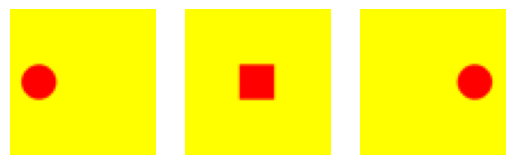

In [8]:
idx = np.random.randint(1, 10000)
label, set = dataset.__getitem__(idx)
print(set.shape, label.shape)
print(idx, label)
plt.subplot(1,3,1)
plt.imshow(np.transpose(set[0:3,:,:], (1,2,0)))
plt.axis(False)
plt.subplot(1,3,2)
plt.imshow(np.transpose(set[3:6,:,:], (1,2,0)))
plt.axis(False)
plt.subplot(1,3,3)
plt.imshow(np.transpose(set[6:9,:,:], (1,2,0)))
plt.axis(False)
plt.show()

In [9]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 99

# Size of feature maps in generator
ngf = 60 #MUST BE DIVISIBLE BY 3!!!

# Size of feature maps in discriminator
ndf = 64


class BigConditionalGenerator(nn.Module):
    def __init__(self):
        super(BigConditionalGenerator, self).__init__()

        self.linear = nn.Sequential(nn.Linear(99+9, nz), nn.ReLU())
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*16) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 32 x 32``
            nn.ConvTranspose2d( ngf * 1, nc * 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc * 3) x 64 x 64``
        )

    def forward(self, input, encoding):
        x = torch.cat((input, encoding), dim=1)
        x = self.linear(x.squeeze())
        x = torch.reshape(x, (-1, nz, 1, 1))
        x = self.main(x)
        
        return x
        
class SetConditionalDiscriminator(nn.Module):
    def __init__(self):
        super(SetConditionalDiscriminator, self).__init__()

        self.linear = nn.Sequential(nn.Linear(9, 64*64), nn.ReLU())

        self.main = nn.Sequential(
            # input is ``(nc*3 + 1) x 64 x 64``
            nn.Conv2d(nc*3 + 1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input, encoding):
        x = self.linear(encoding.squeeze())
        x = torch.reshape(x, (-1, 1, 64, 64))
        x = torch.cat((x, input), dim=1)
        x = self.main(x)
        
        return x

class ImageConditionalDiscriminator(nn.Module):
    def __init__(self):
        super(ImageConditionalDiscriminator, self).__init__()

        self.linear = nn.Sequential(nn.Linear(3, 64*64), nn.ReLU())

        self.main = nn.Sequential(
            # input is ``(nc)+1 x 64 x 64``
            nn.Conv2d(nc + 1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input, encoding):
        x = self.linear(encoding.squeeze())
        x = torch.reshape(x, (-1, 1, 64, 64))
        x = torch.cat((x, input), dim=1)
        x = self.main(x)
        return x

In [10]:
netG = BigConditionalGenerator()
netD = SetConditionalDiscriminator()
netD_img = ImageConditionalDiscriminator()
netG = netG.to(device)
netD = netD.to(device)
netD_img = netD_img.to(device)

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

print('PARAM COUNT: ', get_n_params(netG), get_n_params(netD))

def init_weights(m):
    if type(m) == ConvTranspose2d:
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif type(m) == BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)
        
# initializing the weights
netD.apply(init_weights)
netD_img.apply(init_weights)
netG.apply(init_weights)

PARAM COUNT:  3200751 2813696


BigConditionalGenerator(
  (linear): Sequential(
    (0): Linear(in_features=108, out_features=99, bias=True)
    (1): ReLU()
  )
  (main): Sequential(
    (0): ConvTranspose2d(99, 480, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(480, 240, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(240, 120, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(120, 60, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
 

In [11]:
def setToImgBatch(batch, conditions, batchSize = 60):
    nc = 3
    #batch has shape (batchSize, 3, 128, 128)
    #conditions has shape (batchSize, 9, 1, 1)
    b = batch.shape[0]
    if batchSize == 0:
        return torch.reshape(batch, (b * 3, nc, 64, 64)), torch.reshape(conditions, (b*3, 3, 1, 1))
    else:
        imgs =  torch.reshape(batch, (b * 3, nc, 64, 64))
        conditions = torch.reshape(conditions, (b*3, 3, 1, 1))
        rand_idx = np.random.choice(b*3, batchSize)
        return imgs[rand_idx], conditions[rand_idx]

def generateConditions(N):
    cond = []
    for i in range(N):
        r1, r2, r3 = np.random.randint(1, 4), np.random.randint(1, 4), np.random.randint(1, 4)
        encoding = []
        for r in [r1, r2, r3]:
            if r == 1:
                encoding.extend([1,0,0])
            elif r == 2:
                encoding.extend([0,1,0])
            elif r == 3:
                encoding.extend([0,0,1])
        cond.append(encoding)
    cond = np.float32(np.reshape(np.array(cond), (N, 9, 1, 1)))
    return torch.from_numpy(cond)


            

In [12]:
# Setting up optimizers for both Generator and Discriminator
 
opt_D= optim.Adam(netD.parameters(), lr = 0.0002, betas= (0.5, 0.999))
opt_D_img= optim.Adam(netD_img.parameters(), lr = 0.0002, betas= (0.5, 0.999))
opt_G = optim.Adam(netG.parameters(), lr = 0.0002, betas= (0.5, 0.999))

# Setting up the loss function - BCELoss (to check how far the predicted value is from real value)
loss = BCELoss()
print(device)

cuda:0


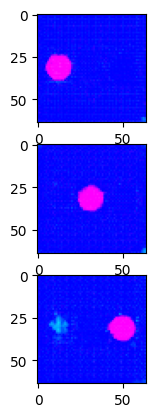

********************
 Epoch 0 and iteration 99 and iterNum 100 
gen loss 6.9848761558532715


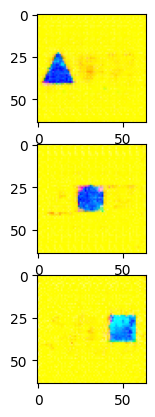

********************
 Epoch 1 and iteration 32 and iterNum 200 
gen loss 5.202174663543701


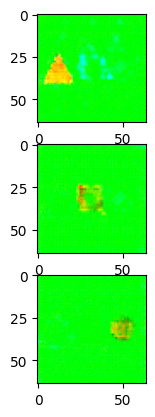

********************
 Epoch 1 and iteration 132 and iterNum 300 
gen loss 5.514883518218994


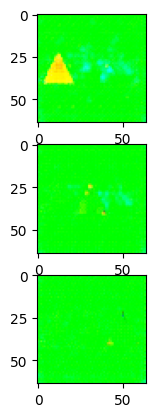

********************
 Epoch 2 and iteration 65 and iterNum 400 
gen loss 6.555840015411377


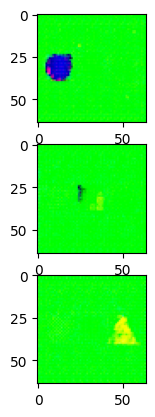

********************
 Epoch 2 and iteration 165 and iterNum 500 
gen loss 5.43428897857666


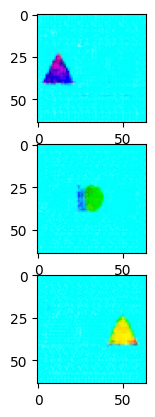

********************
 Epoch 3 and iteration 98 and iterNum 600 
gen loss 9.087942123413086


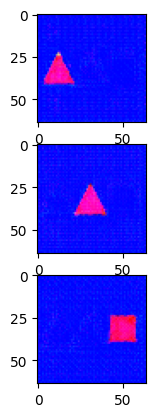

********************
 Epoch 4 and iteration 31 and iterNum 700 
gen loss 5.265453815460205


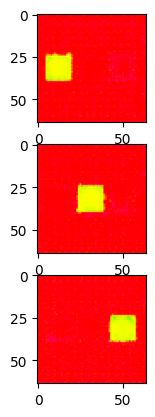

********************
 Epoch 4 and iteration 131 and iterNum 800 
gen loss 3.4793951511383057


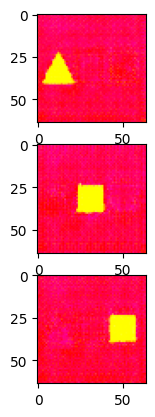

********************
 Epoch 5 and iteration 64 and iterNum 900 
gen loss 3.5382487773895264


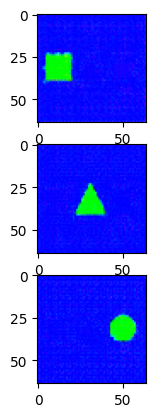

********************
 Epoch 5 and iteration 164 and iterNum 1000 
gen loss 5.845527648925781


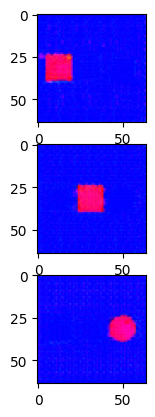

********************
 Epoch 6 and iteration 97 and iterNum 1100 
gen loss 2.885375499725342


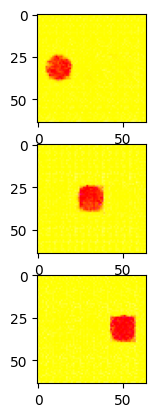

********************
 Epoch 7 and iteration 30 and iterNum 1200 
gen loss 4.21807861328125


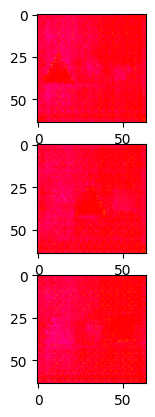

********************
 Epoch 7 and iteration 130 and iterNum 1300 
gen loss 7.277856826782227


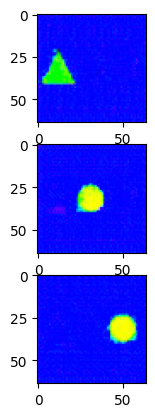

********************
 Epoch 8 and iteration 63 and iterNum 1400 
gen loss 6.926023483276367


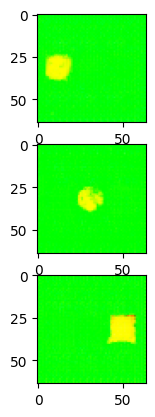

********************
 Epoch 8 and iteration 163 and iterNum 1500 
gen loss 7.554553508758545


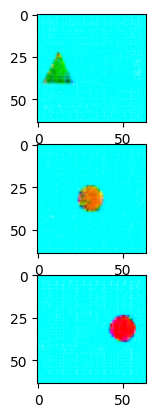

********************
 Epoch 9 and iteration 96 and iterNum 1600 
gen loss 5.89610481262207


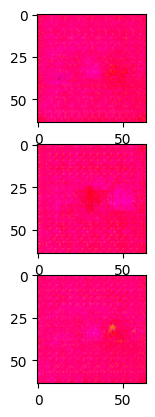

********************
 Epoch 10 and iteration 29 and iterNum 1700 
gen loss 7.9354963302612305


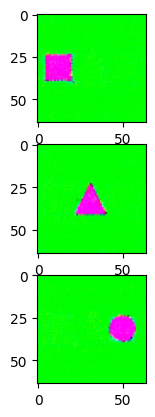

********************
 Epoch 10 and iteration 129 and iterNum 1800 
gen loss 6.689085006713867


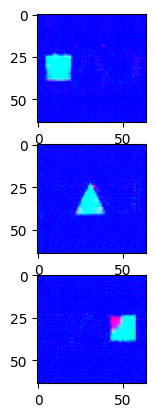

********************
 Epoch 11 and iteration 62 and iterNum 1900 
gen loss 7.848662376403809


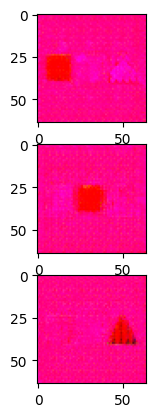

********************
 Epoch 11 and iteration 162 and iterNum 2000 
gen loss 5.206782341003418


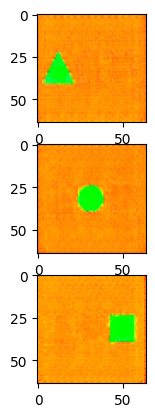

********************
 Epoch 12 and iteration 95 and iterNum 2100 
gen loss 8.052360534667969


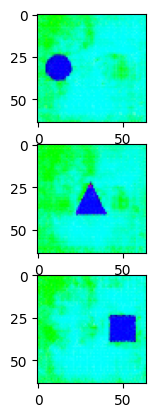

********************
 Epoch 13 and iteration 28 and iterNum 2200 
gen loss 9.240769386291504


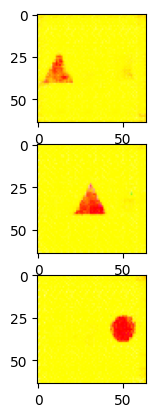

********************
 Epoch 13 and iteration 128 and iterNum 2300 
gen loss 10.60042667388916


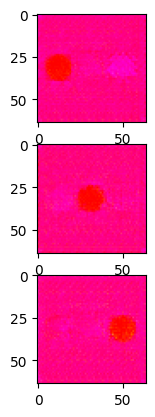

********************
 Epoch 14 and iteration 61 and iterNum 2400 
gen loss 10.51764965057373


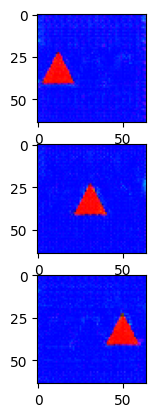

********************
 Epoch 14 and iteration 161 and iterNum 2500 
gen loss 7.750002861022949


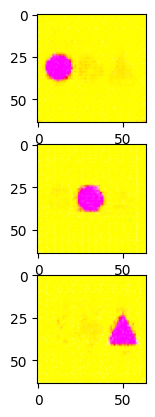

********************
 Epoch 15 and iteration 94 and iterNum 2600 
gen loss 5.150073528289795


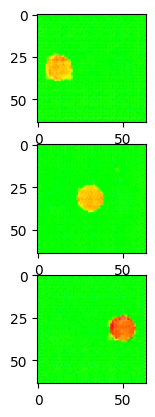

********************
 Epoch 16 and iteration 27 and iterNum 2700 
gen loss 1.1544045209884644


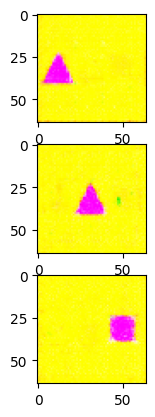

********************
 Epoch 16 and iteration 127 and iterNum 2800 
gen loss 7.010612487792969


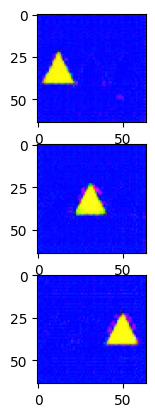

********************
 Epoch 17 and iteration 60 and iterNum 2900 
gen loss 7.941859245300293


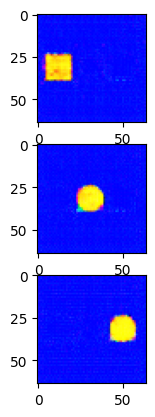

********************
 Epoch 17 and iteration 160 and iterNum 3000 
gen loss 9.785067558288574


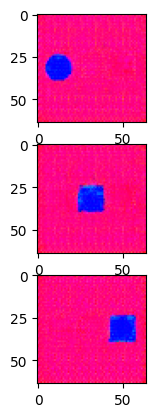

********************
 Epoch 18 and iteration 93 and iterNum 3100 
gen loss 10.401668548583984


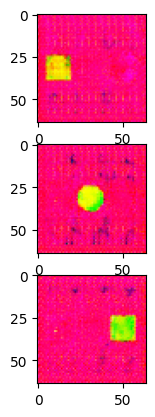

********************
 Epoch 19 and iteration 26 and iterNum 3200 
gen loss 9.49532699584961


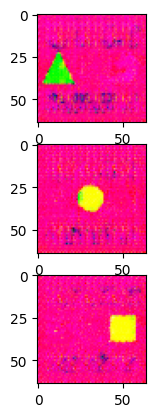

********************
 Epoch 19 and iteration 126 and iterNum 3300 
gen loss 10.705698013305664


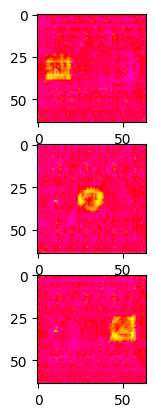

********************
 Epoch 20 and iteration 59 and iterNum 3400 
gen loss 9.820389747619629


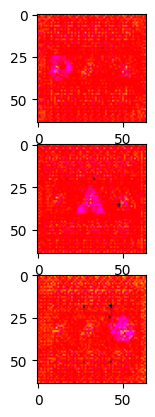

********************
 Epoch 20 and iteration 159 and iterNum 3500 
gen loss 7.948031902313232


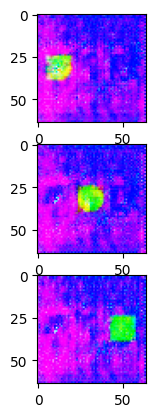

********************
 Epoch 21 and iteration 92 and iterNum 3600 
gen loss 10.23481273651123


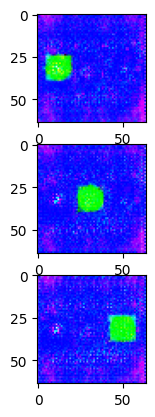

********************
 Epoch 22 and iteration 25 and iterNum 3700 
gen loss 9.756022453308105


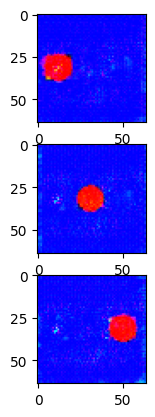

********************
 Epoch 22 and iteration 125 and iterNum 3800 
gen loss 10.63890266418457


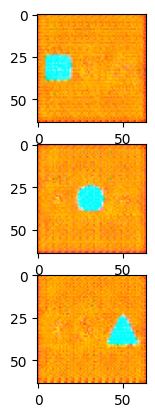

********************
 Epoch 23 and iteration 58 and iterNum 3900 
gen loss 13.24277400970459


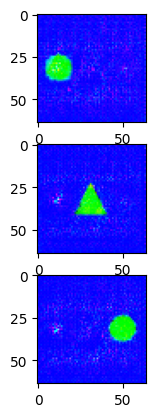

********************
 Epoch 23 and iteration 158 and iterNum 4000 
gen loss 10.58385944366455


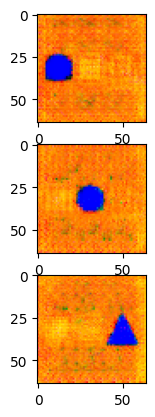

********************
 Epoch 24 and iteration 91 and iterNum 4100 
gen loss 11.6901216506958


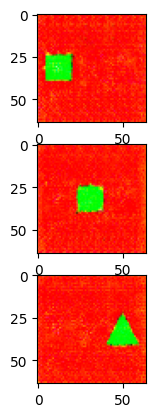

********************
 Epoch 25 and iteration 24 and iterNum 4200 
gen loss 11.289310455322266


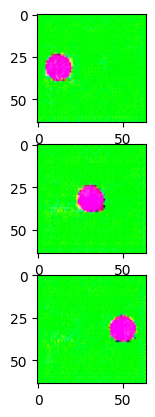

********************
 Epoch 25 and iteration 124 and iterNum 4300 
gen loss 9.558183670043945


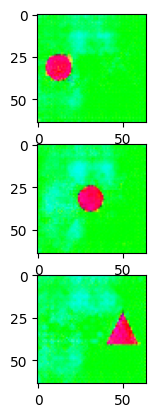

********************
 Epoch 26 and iteration 57 and iterNum 4400 
gen loss 9.24609661102295


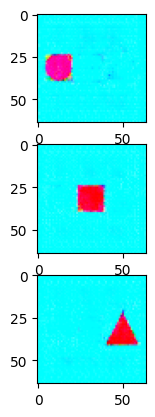

********************
 Epoch 26 and iteration 157 and iterNum 4500 
gen loss 9.839577674865723


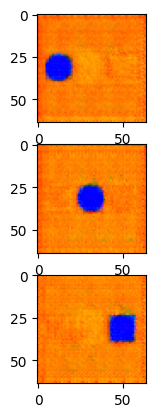

********************
 Epoch 27 and iteration 90 and iterNum 4600 
gen loss 11.100061416625977


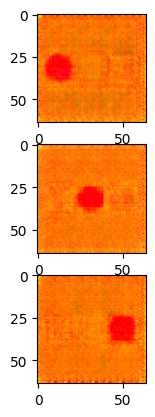

********************
 Epoch 28 and iteration 23 and iterNum 4700 
gen loss 10.449270248413086


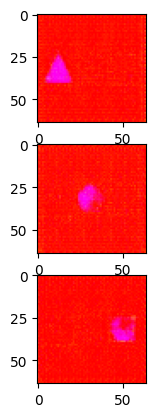

********************
 Epoch 28 and iteration 123 and iterNum 4800 
gen loss 2.540877103805542


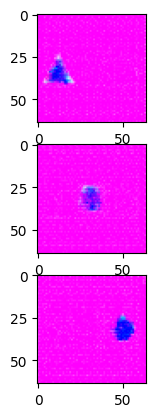

********************
 Epoch 29 and iteration 56 and iterNum 4900 
gen loss 5.698254108428955


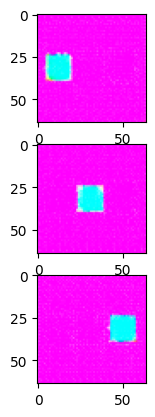

********************
 Epoch 29 and iteration 156 and iterNum 5000 
gen loss 5.559063911437988


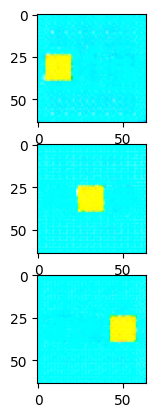

********************
 Epoch 30 and iteration 89 and iterNum 5100 
gen loss 5.622651100158691


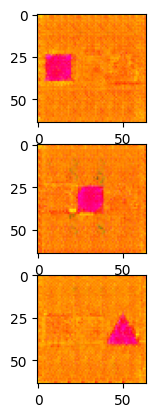

********************
 Epoch 31 and iteration 22 and iterNum 5200 
gen loss 6.116164684295654


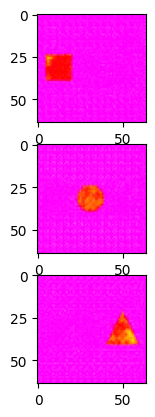

********************
 Epoch 31 and iteration 122 and iterNum 5300 
gen loss 4.786638259887695


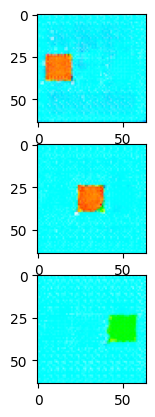

********************
 Epoch 32 and iteration 55 and iterNum 5400 
gen loss 5.546201705932617


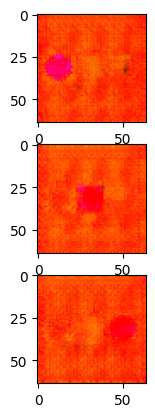

********************
 Epoch 32 and iteration 155 and iterNum 5500 
gen loss 7.436617374420166


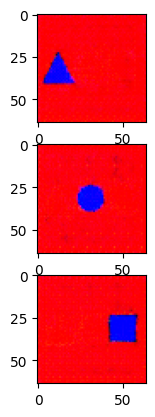

********************
 Epoch 33 and iteration 88 and iterNum 5600 
gen loss 3.6870522499084473


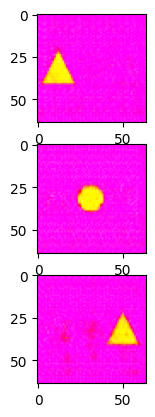

********************
 Epoch 34 and iteration 21 and iterNum 5700 
gen loss 8.260415077209473


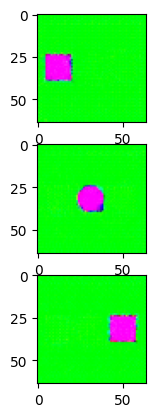

********************
 Epoch 34 and iteration 121 and iterNum 5800 
gen loss 6.286686420440674


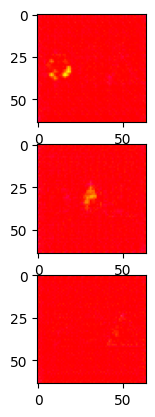

********************
 Epoch 35 and iteration 54 and iterNum 5900 
gen loss 4.388534069061279


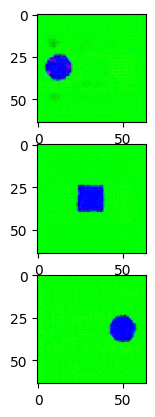

********************
 Epoch 35 and iteration 154 and iterNum 6000 
gen loss 6.629752159118652


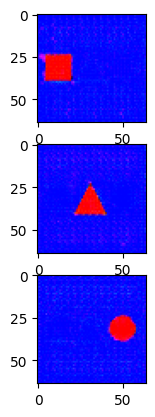

********************
 Epoch 36 and iteration 87 and iterNum 6100 
gen loss 7.502235412597656


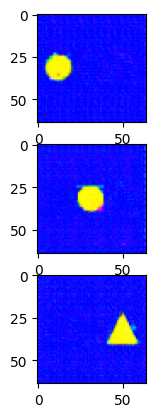

********************
 Epoch 37 and iteration 20 and iterNum 6200 
gen loss 5.89682149887085


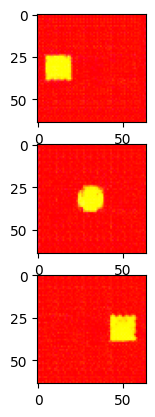

********************
 Epoch 37 and iteration 120 and iterNum 6300 
gen loss 6.745953559875488


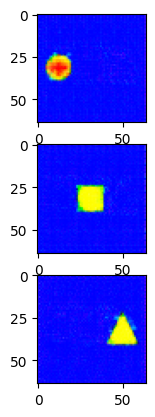

********************
 Epoch 38 and iteration 53 and iterNum 6400 
gen loss 6.188414096832275


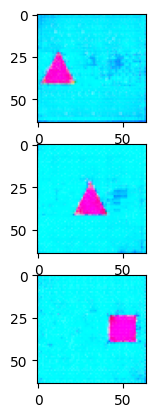

********************
 Epoch 38 and iteration 153 and iterNum 6500 
gen loss 7.0178351402282715


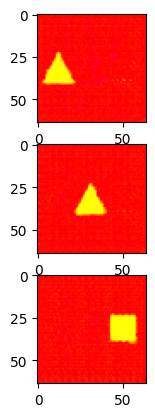

********************
 Epoch 39 and iteration 86 and iterNum 6600 
gen loss 8.209365844726562


KeyboardInterrupt: 

In [185]:
# TRAINING GANS
epochs = 100
iterNum = 0
loss_image_coef = 1
loss_set_coef = 1
beta = 1e9
# going over the entire dataset epochs times
for e in range(epochs):
     
    # pick each batch b of input images: shape of each batch is (32, 3, 32, 32)
    for i, batch in enumerate(dataloader):
        labels = torch.reshape(batch[0], (-1, 9, 1, 1))
        b = batch[1]
        iterNum += 1
        ##########################
        ## Update Set Discriminator ##
        ##########################
 
        # Loss on real images
         
        # clear the gradient
        opt_D.zero_grad() # set the gradients to 0 at start of each loop because gradients are accumulated on subsequent backward passes
        # compute the D model output
        yhat = netD(b.to(device), labels.to(device)).view(-1) # view(-1) reshapes a 4-d tensor of shape (2,1,1,1) to 1-d tensor with 2 values only
        # specify target labels or true labels
        target = torch.ones(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_real = loss(yhat, target)
        # calculate gradients -  or rather accumulation of gradients on loss tensor
        loss_real.backward()
 
        # Loss on fake images
 
        # generate batch of fake images using G
        # Step1: creating noise to be fed as input to G
        noise = torch.randn(len(b), nz, 1, 1, device = device)
        fake_enc = generateConditions(len(b))
        # Step 2: feed noise to G to create a fake img (this will be reused when updating G)
        fake_set = netG(noise, fake_enc.to(device)) # (batchsize, 9, 64, 64)

        loss_fake = 0

        # compute D model output on fake images
        yhat = netD(fake_set.detach(), fake_enc.to(device)).view(-1) # .cuda() is essential because our input i.e. fake_img is on gpu but model isnt (runtimeError thrown); detach is imp: Basically, only track steps on your generator optimizer when training the generator, NOT the discriminator. 
        # specify target labels
        target = torch.zeros(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_fake += loss(yhat, target)
        # calculate gradients
        loss_fake.backward()
 
        # total error on D
        loss_disc = loss_real + loss_fake
 
        # Update weights of D
        opt_D.step()

        ##########################
        #### Update Generator on Set Discriminator Loss####
        ##########################
 
        # clear gradient
        opt_G.zero_grad()


        # pass fake image through D
        yhat = netD(fake_set.to(device), fake_enc.to(device)).view(-1)
        # specify target variables - remember G wants D *to think* these are real images so label is 1
        target = torch.ones(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_gen = loss_set_coef * loss(yhat, target)
        loss_gen_set = loss_gen # for tracking
        # calculate gradients
        loss_gen.backward()
        # update weights on G
        opt_G.step()

        ##########################
        ## Update Image Discriminator ##
        ##########################
 
        # Loss on real images
        b_img, b_enc =  setToImgBatch(b, labels, batchSize = 60)
        # clear the gradient
        opt_D_img.zero_grad() # set the gradients to 0 at start of each loop because gradients are accumulated on subsequent backward passes
        # compute the D model output
        yhat = netD_img(b_img.to(device), b_enc.to(device)).view(-1) # view(-1) reshapes a 4-d tensor of shape (2,1,1,1) to 1-d tensor with 2 values only
        # specify target labels or true labels
        target = torch.ones(len(b_img), dtype=torch.float, device=device)
        # calculate loss
        loss_real = loss(yhat, target)
        # calculate gradients -  or rather accumulation of gradients on loss tensor
        loss_real.backward()
 
        # Loss on fake images
 
        # generate batch of fake images using G
        # Step1: creating noise to be fed as input to G
        noise = torch.randn(len(b_img), nz, 1, 1, device = device)
        fake_enc = generateConditions(len(b_img))
        # Step 2: feed noise to G to create a fake img (this will be reused when updating G)
        fake_set = netG(noise, fake_enc.to(device)) # (batchsize, 3, 128, 128)
        fake_set_new, fake_enc_new = setToImgBatch(fake_set, fake_enc, batchSize = len(b_img))
        loss_fake = 0
        # compute D model output on fake images
        yhat = netD_img(fake_set_new.detach().to(device), fake_enc_new.detach().to(device)).view(-1) # .cuda() is essential because our input i.e. fake_img is on gpu but model isnt (runtimeError thrown); detach is imp: Basically, only track steps on your generator optimizer when training the generator, NOT the discriminator. 
        # specify target labels
        target = torch.zeros(len(yhat), dtype=torch.float, device=device)
        # calculate loss
        loss_fake += loss(yhat, target)
        # calculate gradients
        loss_fake.backward()
 
        # total error on D
        loss_disc = loss_real + loss_fake
 
        # Update weights of D
        opt_D_img.step()

        ##########################
        #### Update Generator on Image Discriminator Loss####
        ##########################
 
        # clear gradient
        opt_G.zero_grad()
        
        # pass fake image through D
        yhat = netD_img(fake_set_new.to(device), fake_enc_new.to(device)).view(-1)
        # specify target variables - remember G wants D *to think* these are real images so label is 1
        target = torch.ones(len(yhat), dtype=torch.float, device=device)
        # calculate loss
        loss_gen = loss_image_coef * loss(yhat, target)
        loss_gen_img = loss_gen #for tracking
        # calculate gradients
        loss_gen.backward()
        # update weights on G
        opt_G.step()

 
        ####################################
        #### Plot some Generator images ####
        ####################################
 
        # during every epoch, print images at every 10th iteration.
        if iterNum% 100 == 0:
            # convert the fake images from (b_size, 3, 32, 32) to (b_size, 32, 32, 3) for plotting
            imgs_plot = []
            sub = 1
            fake_set_sample = fake_set[0]
            img0 = np.transpose(fake_set_sample[0:3,:,:].detach().cpu(), (1, 2, 0))
            img1 = np.transpose(fake_set_sample[3:6,:,:].detach().cpu(), (1, 2, 0))
            img2 = np.transpose(fake_set_sample[6:9,:,:].detach().cpu(), (1, 2, 0))
            plt.subplot(3,1,1)
            plt.imshow(img0)
            plt.subplot(3,1,2)
            plt.imshow(img1)
            plt.subplot(3,1,3)
            plt.imshow(img2)
            plt.show()
            print("********************")
            print(" Epoch %d and iteration %d and iterNum %d " % (e, i, iterNum))
            print('gen loss', loss_gen.item())

tensor([0., 1., 0., 1., 0., 0., 1., 0., 0.])


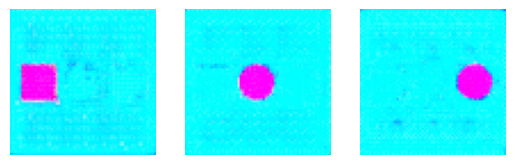

In [231]:
noise = torch.randn(20, nz, 1, 1, device = device)
cond = generateConditions(20)
print(cond[0].squeeze())

output = netG(noise.to(device), cond.to(device))
fake_set_sample = output[0]
img0 = np.transpose(fake_set_sample[0:3,:,:].detach().cpu(), (1, 2, 0))
img1 = np.transpose(fake_set_sample[3:6,:,:].detach().cpu(), (1, 2, 0))
img2 = np.transpose(fake_set_sample[6:9,:,:].detach().cpu(), (1, 2, 0))

fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(img0)
plt.axis(False)
plt.subplot(1,3,2)
plt.imshow(img1)
plt.axis(False)
plt.subplot(1,3,3)
plt.imshow(img2)
plt.axis(False)
plt.show()

In [229]:
filename = 'oy2.png' 
fig.savefig(filename, dpi=fig.dpi)

In [232]:
!zip -r output3.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/og2.png (deflated 3%)
  adding: kaggle/working/brb2.png (deflated 4%)
  adding: kaggle/working/bp2.png (deflated 3%)
  adding: kaggle/working/pr2.png (deflated 3%)
  adding: kaggle/working/pr3.png (deflated 3%)
  adding: kaggle/working/pb3.png (deflated 5%)
  adding: kaggle/working/py.png (deflated 5%)
  adding: kaggle/working/bg.png (deflated 3%)
  adding: kaggle/working/og.png (deflated 3%)
  adding: kaggle/working/oy2.png (deflated 3%)
  adding: kaggle/working/pb2.png (deflated 3%)
  adding: kaggle/working/oy.png (deflated 3%)
  adding: kaggle/working/pr.png (deflated 3%)
  adding: kaggle/working/ob.png (deflated 3%)
  adding: kaggle/working/ry.png (deflated 4%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/pgy.png (deflated 3%)
  adding: kaggle/working/output2.zip (stored 0%)
  adding: kaggle/working/rb.png (deflated 3%)
  adding: kaggle/working/yb.png (deflated 5%)
  adding: kaggle/w

In [233]:
for file in os.listdir(os.getcwd()):
    if file.endswith('.png'):
        os.remove(file)